# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import log_loss, roc_auc_score, plot_roc_curve, plot_confusion_matrix, confusion_matrix, make_scorer
from sklearn.metrics import balanced_accuracy_score, dcg_score, roc_auc_score, average_precision_score, roc_curve

import xgboost as xgb

import seaborn as sns

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

#from costcla.metrics import cost_loss

from features import update_dataset_features, text_to_binary, add_extra_features, encode
from eval_metrics import savings

pd.set_option("display.max_columns",500)
plt.style.use('ggplot')

In [2]:
data_path = r"./train.csv"
image_dir = r"./images/"

In [3]:
df = pd.read_csv(data_path, sep=";", encoding="utf-8-sig")

In [ ]:
#df["claim_date_occured"] = pd.to_datetime(df["claim_date_occured"], format="%Y%m%d")
#min(df["claim_date_occured"].dt.year - df["policy_holder_year_birth"])

# Exploratory Data Analysis (EDA)

In [6]:
# check imbalance
df["fraud"].replace({"N":0, "Y":1}).sum() / len(df["fraud"]) * 100

0.5553251717361124

In [12]:
pd.crosstab(df["fraud"], df["claim_vehicle_brand"], normalize=True)

claim_vehicle_brand,ALFA ROMEO,AUDI,BMW,CHEVROLET,CHRYSLER,CITROEN,DACIA,DODGE,FIAT,FORD,...,PORSCHE,RENAULT,SAAB,SEAT,SKODA,SSANGYONG,SUZUKI,TOYOTA,VOLKSWAGEN,VOLVO
fraud,,,,,,,,,,,,,,,,,,,,,
N,0.007205,0.045336,0.054056,0.008610,0.001625,0.083533,0.019000,0.001801,0.028269,0.082083,...,0.001757,0.076746,0.00224,0.019285,0.020449,0.001428,0.010939,0.043622,0.107211,0.019461
Y,0.000066,0.000351,0.000681,0.000022,0.000022,0.000483,0.000198,0.000000,0.000264,0.000351,...,0.000044,0.000351,0.00000,0.000066,0.000088,0.000000,0.000066,0.000132,0.000593,0.000088


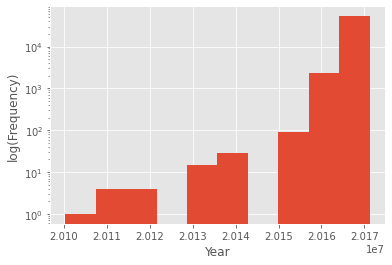

In [7]:
# graph for claim_date_occurred
df["claim_date_occured"].plot(kind='hist', logy=True)
plt.ylabel('log(Frequency)')
plt.xlabel('Year')
plt.savefig(image_dir + 'claim_date_occurred.png')

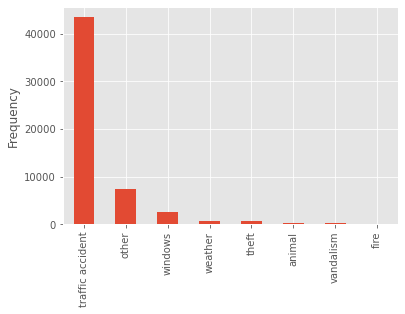

In [8]:
# graph for claim_cause
df["claim_cause"].value_counts().plot(kind='bar')
plt.ylabel("Frequency")
plt.savefig(image_dir + 'claim_cause.png')

In [17]:
postal_bins = [999, 1299, 1499, 1999, 2999, 3499, 3999, 4999, 5999, 6599, 6999, 7999, 8999, 9999]
postal_label = ["brussel", "waals_brabant", "vlaams_brabant", 'Antwerpen', 'vlaams_brabant', 'limburg', 
                'luik', 'namen', 'henegouwen', 'luxemburg', 'henegouwen', 'w-vlaanderen', 'o-vlaanderen']
df["province"] = pd.cut(df["claim_postal_code"], postal_bins, labels=postal_label, ordered=False)

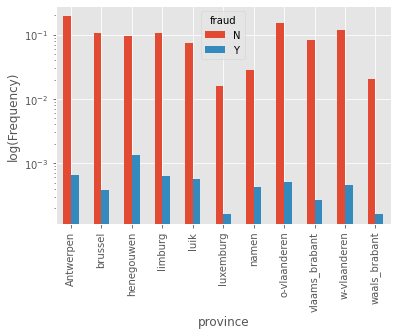

In [26]:
pd.crosstab(df["province"], df["fraud"], normalize=True).plot.bar()
plt.yscale('log')
plt.ylabel('log(Frequency)')
plt.savefig(image_dir + 'province.png')

claim_id


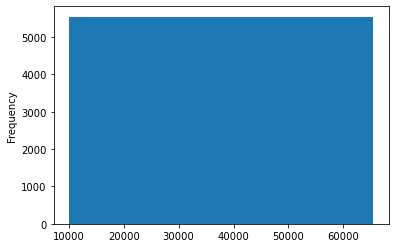

count    55463.000000
mean     37734.210825
std      16012.679701
min      10000.000000
25%      23867.500000
50%      37734.000000
75%      51601.500000
max      65468.000000
Name: claim_id, dtype: float64
*************************************************************************
fraud


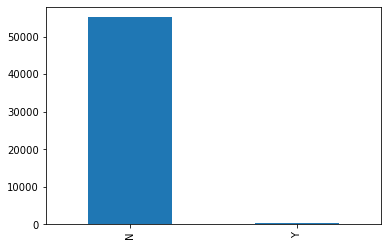

count     55463
unique        2
top           N
freq      55155
Name: fraud, dtype: object
*************************************************************************
claim_amount
*******too many values to plot*******************
count      55463
unique     48731
top       169,00
freq          23
Name: claim_amount, dtype: object
*************************************************************************
claim_date_registered


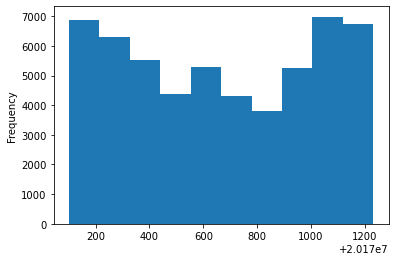

count    5.546300e+04
mean     2.017067e+07
std      3.457509e+02
min      2.017010e+07
25%      2.017040e+07
50%      2.017063e+07
75%      2.017100e+07
max      2.017123e+07
Name: claim_date_registered, dtype: float64
*************************************************************************
claim_date_occured


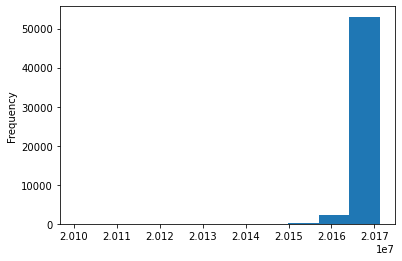

count    5.546300e+04
mean     2.017019e+07
std      2.394936e+03
min      2.010032e+07
25%      2.017032e+07
50%      2.017061e+07
75%      2.017092e+07
max      2.017123e+07
Name: claim_date_occured, dtype: float64
*************************************************************************
claim_time_occured


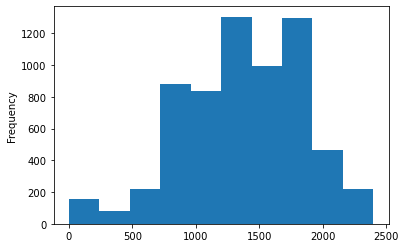

count    6453.000000
mean     1360.452503
std       472.532826
min         0.000000
25%      1000.000000
50%      1400.000000
75%      1730.000000
max      2400.000000
Name: claim_time_occured, dtype: float64
*************************************************************************
claim_postal_code


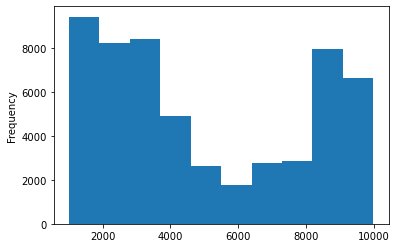

count    55463.000000
mean      4939.372951
std       2985.665452
min       1000.000000
25%       2310.000000
50%       3950.000000
75%       8400.000000
max       9991.000000
Name: claim_postal_code, dtype: float64
*************************************************************************
claim_cause


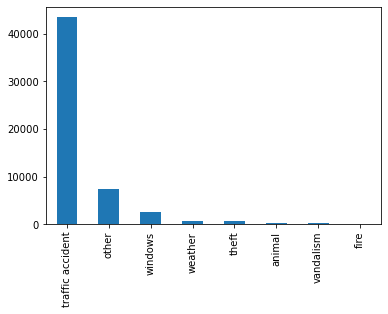

count                55463
unique                   8
top       traffic accident
freq                 43496
Name: claim_cause, dtype: object
*************************************************************************
claim_liable


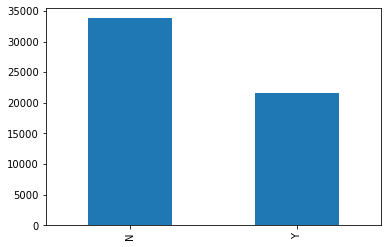

count     55463
unique        2
top           N
freq      33803
Name: claim_liable, dtype: object
*************************************************************************
claim_num_injured


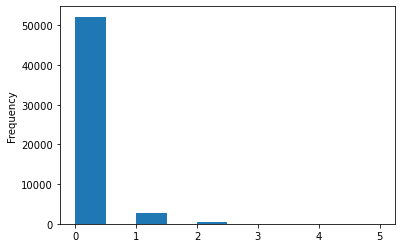

count    55463.000000
mean         0.072030
std          0.314657
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: claim_num_injured, dtype: float64
*************************************************************************
claim_num_third_parties


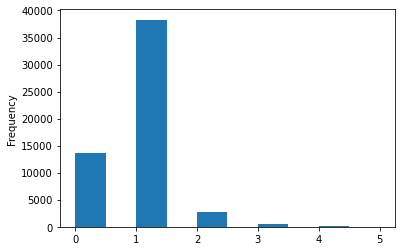

count    55463.000000
mean         0.831419
std          0.580161
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: claim_num_third_parties, dtype: float64
*************************************************************************
claim_num_vehicles


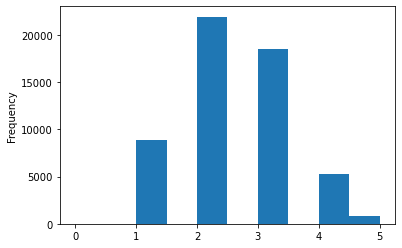

count    55463.000000
mean         2.408489
std          0.918571
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: claim_num_vehicles, dtype: float64
*************************************************************************
claim_police


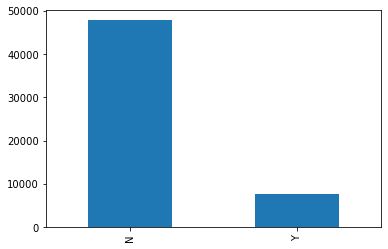

count     55463
unique        2
top           N
freq      47819
Name: claim_police, dtype: object
*************************************************************************
claim_alcohol


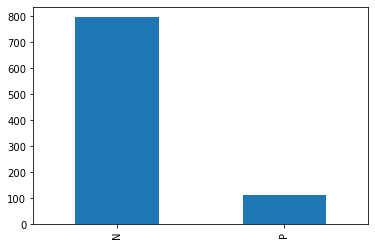

count     908
unique      2
top         N
freq      796
Name: claim_alcohol, dtype: object
*************************************************************************
claim_language


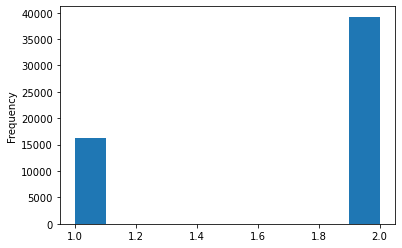

count    55420.000000
mean         1.708102
std          0.454640
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: claim_language, dtype: float64
*************************************************************************
claim_vehicle_id
*******too many values to plot*******************
count                                           45136
unique                                          40611
top       OGYwZjFlNmQ5NDczNzM1ZTk3Y2I0ODQ1OGZkODRkYWI
freq                                                6
Name: claim_vehicle_id, dtype: object
*************************************************************************
claim_vehicle_brand
*******too many values to plot*******************
count          45527
unique            35
top       VOLKSWAGEN
freq            4908
Name: claim_vehicle_brand, dtype: object
*************************************************************************
claim_vehicle_type


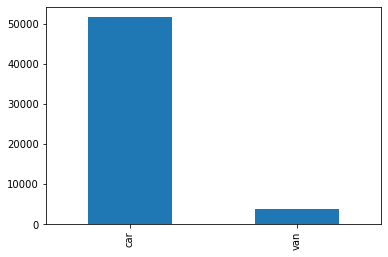

count     55309
unique        2
top         car
freq      51552
Name: claim_vehicle_type, dtype: object
*************************************************************************
claim_vehicle_date_inuse


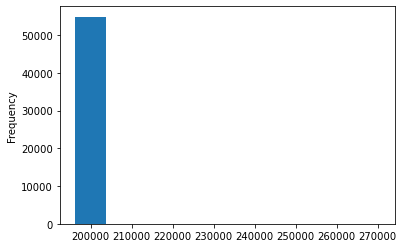

count     54849.000000
mean     200884.814637
std         585.577671
min      196204.000000
25%      200604.000000
50%      201006.000000
75%      201303.000000
max      270505.000000
Name: claim_vehicle_date_inuse, dtype: float64
*************************************************************************
claim_vehicle_cyl


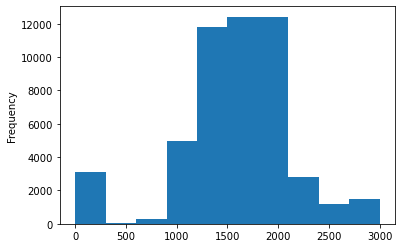

count    50546.000000
mean      1579.646283
std        569.124114
min          0.000000
25%       1360.000000
50%       1587.000000
75%       1968.000000
max       3000.000000
Name: claim_vehicle_cyl, dtype: float64
*************************************************************************
claim_vehicle_load


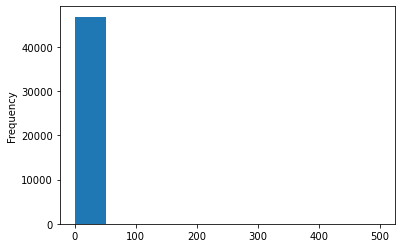

count    46846.000000
mean         1.927318
std          2.343768
min          0.600000
25%          1.610000
50%          1.850000
75%          2.070000
max        500.000000
Name: claim_vehicle_load, dtype: float64
*************************************************************************
claim_vehicle_fuel_type


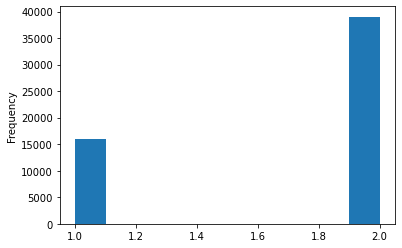

count    55027.000000
mean         1.709070
std          0.454195
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: claim_vehicle_fuel_type, dtype: float64
*************************************************************************
claim_vehicle_power


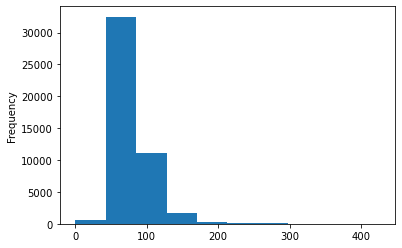

count    46315.000000
mean        78.681485
std         27.994627
min          0.000000
25%         59.000000
50%         76.000000
75%         91.000000
max        426.000000
Name: claim_vehicle_power, dtype: float64
*************************************************************************
policy_holder_id
*******too many values to plot*******************
count                                           55463
unique                                          28519
top       MTNlMmVhMzM4ZWMzNDIyMTY2OTJhN2EwY2E1YmI2N2I
freq                                              124
Name: policy_holder_id, dtype: object
*************************************************************************
policy_holder_postal_code


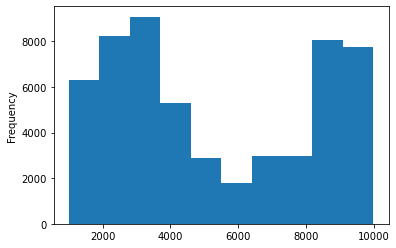

count    55352.000000
mean      5246.050911
std       2910.040457
min       1000.000000
25%       2620.000000
50%       4280.000000
75%       8500.000000
max       9992.000000
Name: policy_holder_postal_code, dtype: float64
*************************************************************************
policy_holder_form


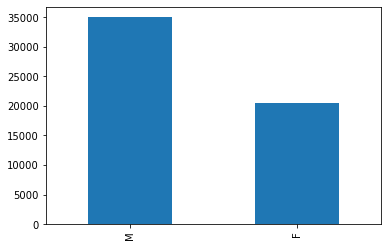

count     55463
unique        2
top           M
freq      35002
Name: policy_holder_form, dtype: object
*************************************************************************
policy_holder_year_birth


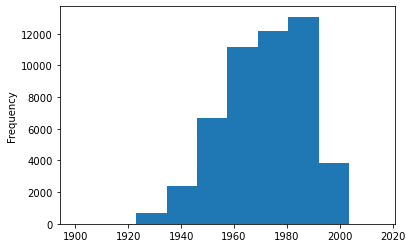

count    50082.000000
mean      1971.282716
std         15.512778
min       1900.000000
25%       1960.000000
50%       1973.000000
75%       1984.000000
max       2015.000000
Name: policy_holder_year_birth, dtype: float64
*************************************************************************
policy_holder_country


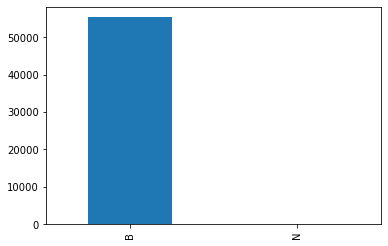

count     55463
unique        2
top           B
freq      55352
Name: policy_holder_country, dtype: object
*************************************************************************
policy_holder_expert_id
*******too many values to plot*******************
count                                            9578
unique                                             75
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                             1332
Name: policy_holder_expert_id, dtype: object
*************************************************************************
driver_id
*******too many values to plot*******************
count                                           55463
unique                                          26765
top       ZDEyMDQzM2I3MDE5MWMyODgwNThmNDkyZDczMjQ1ZGY
freq                                              437
Name: driver_id, dtype: object
*************************************************************************
driver_postal_code


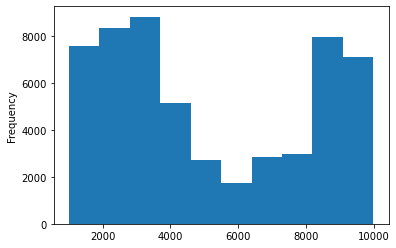

count    55390.000000
mean      5095.559523
std       2937.484639
min       1000.000000
25%       2490.000000
50%       4020.000000
75%       8450.000000
max       9992.000000
Name: driver_postal_code, dtype: float64
*************************************************************************
driver_form


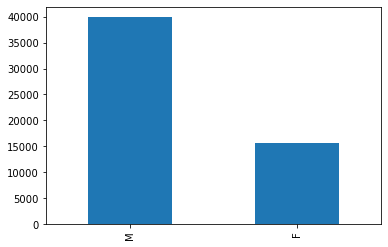

count     55463
unique        2
top           M
freq      39912
Name: driver_form, dtype: object
*************************************************************************
driver_year_birth


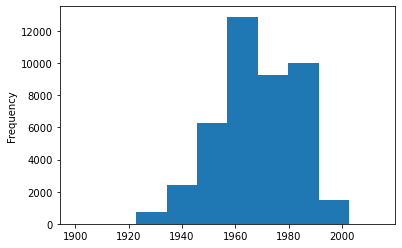

count    43097.000000
mean      1967.929786
std         14.893063
min       1900.000000
25%       1958.000000
50%       1968.000000
75%       1980.000000
max       2014.000000
Name: driver_year_birth, dtype: float64
*************************************************************************
driver_country


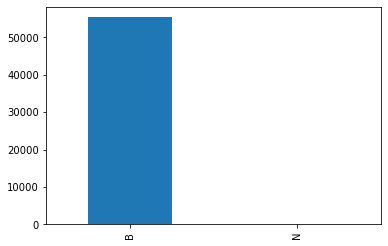

count     55463
unique        2
top           B
freq      55390
Name: driver_country, dtype: object
*************************************************************************
driver_expert_id
*******too many values to plot*******************
count                                           13746
unique                                             77
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                             1878
Name: driver_expert_id, dtype: object
*************************************************************************
driver_injured


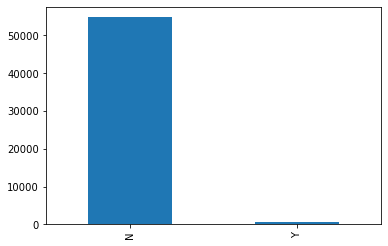

count     55463
unique        2
top           N
freq      54818
Name: driver_injured, dtype: object
*************************************************************************
driver_vehicle_id
*******too many values to plot*******************
count                                           45147
unique                                          40618
top       OGYwZjFlNmQ5NDczNzM1ZTk3Y2I0ODQ1OGZkODRkYWI
freq                                                6
Name: driver_vehicle_id, dtype: object
*************************************************************************
third_party_1_id
*******too many values to plot*******************
count                                           41722
unique                                          28723
top       NTg0ODNiYTYwODI0MGU0MzRlODM2MGNkYWI5NGNkODY
freq                                              119
Name: third_party_1_id, dtype: object
*************************************************************************
third_party_1_postal_code


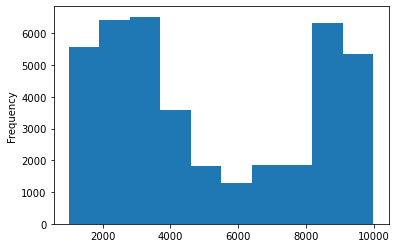

count    40618.000000
mean      5106.696612
std       2980.397851
min       1000.000000
25%       2450.000000
50%       4000.000000
75%       8501.000000
max       9992.000000
Name: third_party_1_postal_code, dtype: float64
*************************************************************************
third_party_1_injured


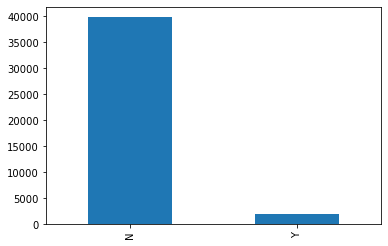

count     41722
unique        2
top           N
freq      39808
Name: third_party_1_injured, dtype: object
*************************************************************************
third_party_1_vehicle_type


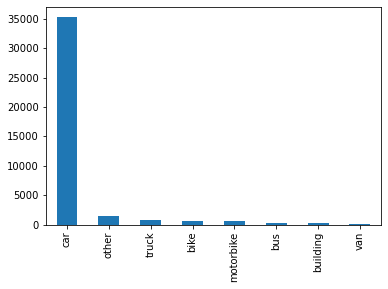

count     39423
unique        8
top         car
freq      35227
Name: third_party_1_vehicle_type, dtype: object
*************************************************************************
third_party_1_form


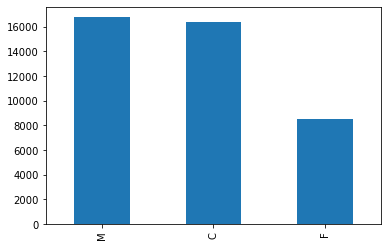

count     41722
unique        3
top           M
freq      16779
Name: third_party_1_form, dtype: object
*************************************************************************
third_party_1_year_birth


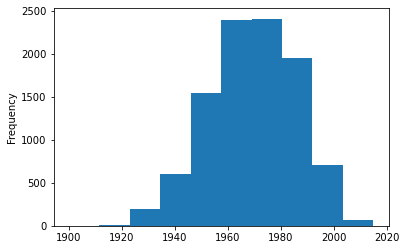

count    9870.000000
mean     1969.229281
std        16.253359
min      1900.000000
25%      1958.000000
50%      1969.000000
75%      1982.000000
max      2015.000000
Name: third_party_1_year_birth, dtype: float64
*************************************************************************
third_party_1_country


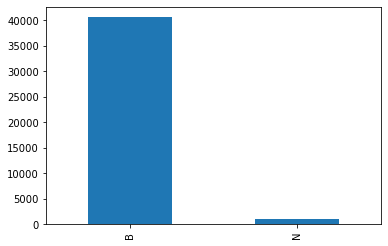

count     41722
unique        2
top           B
freq      40618
Name: third_party_1_country, dtype: object
*************************************************************************
third_party_1_vehicle_id
*******too many values to plot*******************
count                                           36551
unique                                          35670
top       NTA1OGYxYWY4Mzg4NjMzZjYwOWNhZGI3NWE3NWRjOWQ
freq                                              166
Name: third_party_1_vehicle_id, dtype: object
*************************************************************************
third_party_1_expert_id
*******too many values to plot*******************
count                                             654
unique                                             72
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                               71
Name: third_party_1_expert_id, dtype: object
*************************************************************************

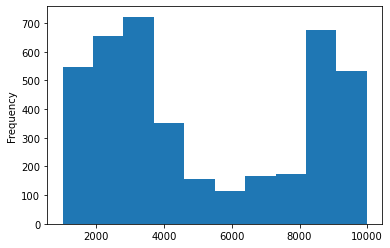

count    4091.000000
mean     5099.257639
std      2994.791439
min      1000.000000
25%      2480.000000
50%      3920.000000
75%      8550.000000
max      9991.000000
Name: third_party_2_postal_code, dtype: float64
*************************************************************************
third_party_2_injured


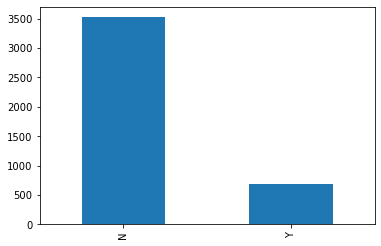

count     4218
unique       2
top          N
freq      3525
Name: third_party_2_injured, dtype: object
*************************************************************************
third_party_2_vehicle_type


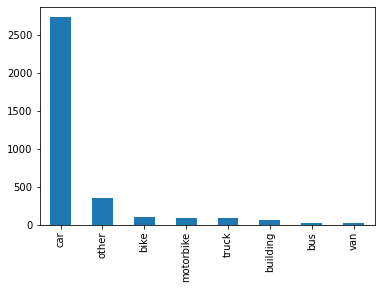

count     3462
unique       8
top        car
freq      2730
Name: third_party_2_vehicle_type, dtype: object
*************************************************************************
third_party_2_form


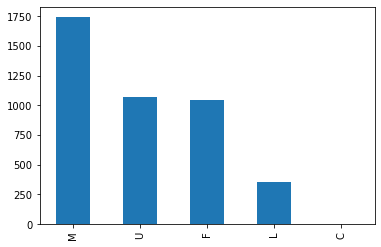

count     4218
unique       5
top          M
freq      1742
Name: third_party_2_form, dtype: object
*************************************************************************
third_party_2_year_birth


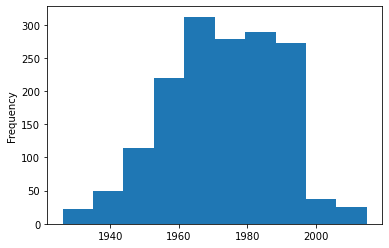

count    1621.000000
mean     1973.099321
std        16.535092
min      1926.000000
25%      1962.000000
50%      1974.000000
75%      1986.000000
max      2015.000000
Name: third_party_2_year_birth, dtype: float64
*************************************************************************
third_party_2_country


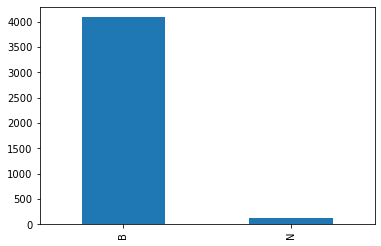

count     4218
unique       2
top          B
freq      4091
Name: third_party_2_country, dtype: object
*************************************************************************
third_party_2_vehicle_id
*******too many values to plot*******************
count                                            2868
unique                                           2821
top       NTA1OGYxYWY4Mzg4NjMzZjYwOWNhZGI3NWE3NWRjOWQ
freq                                               16
Name: third_party_2_vehicle_id, dtype: object
*************************************************************************
third_party_2_expert_id
*******too many values to plot*******************
count                                              27
unique                                             22
top       OGQ2ZTAzMzJmYjBmYWY2MjJjNzZkZmNhYTFhZWZmY2M
freq                                                2
Name: third_party_2_expert_id, dtype: object
*************************************************************************
thi

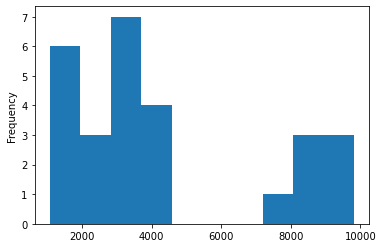

count      27.000000
mean     4214.518519
std      2810.049361
min      1070.000000
25%      2235.000000
50%      3390.000000
75%      5700.000000
max      9820.000000
Name: third_party_3_postal_code, dtype: float64
*************************************************************************
third_party_3_injured


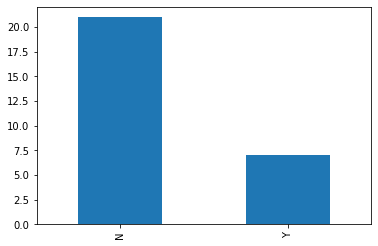

count     28
unique     2
top        N
freq      21
Name: third_party_3_injured, dtype: object
*************************************************************************
third_party_3_vehicle_type


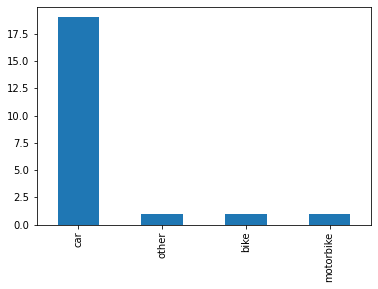

count      22
unique      4
top       car
freq       19
Name: third_party_3_vehicle_type, dtype: object
*************************************************************************
third_party_3_form


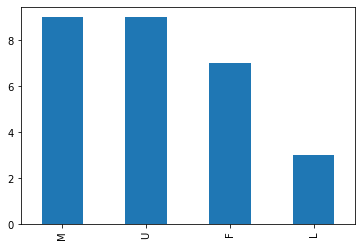

count     28
unique     4
top        M
freq       9
Name: third_party_3_form, dtype: object
*************************************************************************
third_party_3_year_birth


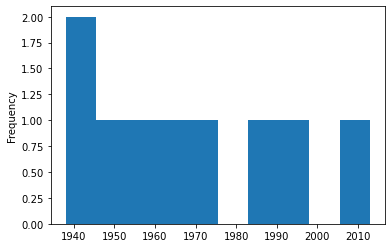

count       9.000000
mean     1968.666667
std        25.238859
min      1938.000000
25%      1952.000000
50%      1961.000000
75%      1984.000000
max      2013.000000
Name: third_party_3_year_birth, dtype: float64
*************************************************************************
third_party_3_country


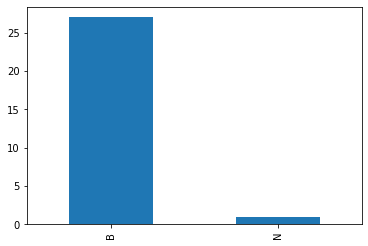

count     28
unique     2
top        B
freq      27
Name: third_party_3_country, dtype: object
*************************************************************************
third_party_3_vehicle_id
*******too many values to plot*******************
count                                              18
unique                                             18
top       ODg3YmQxMWUyNWVkYzIyMGY3ZGNmMGQ1YjlhNzkzNDk
freq                                                1
Name: third_party_3_vehicle_id, dtype: object
*************************************************************************
third_party_3_expert_id


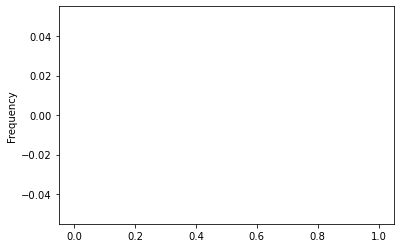

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: third_party_3_expert_id, dtype: float64
*************************************************************************
repair_id
*******too many values to plot*******************
count                                           25345
unique                                           4831
top       NzRjYTk0N2NiMTU4ZWYwMTdiM2Y1NTZiNjFiM2QxY2Y
freq                                              335
Name: repair_id, dtype: object
*************************************************************************
repair_postal_code


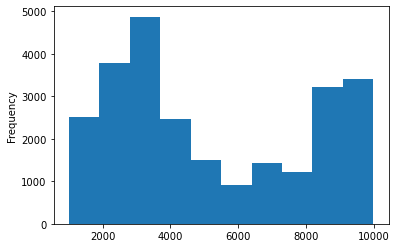

count    25323.000000
mean      5147.263042
std       2826.016355
min       1000.000000
25%       2800.000000
50%       4030.000000
75%       8400.000000
max       9992.000000
Name: repair_postal_code, dtype: float64
*************************************************************************
repair_form


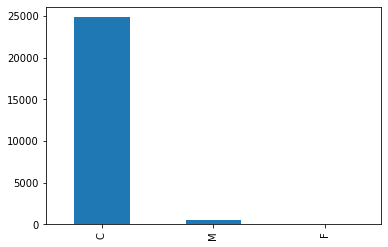

count     25345
unique        3
top           C
freq      24853
Name: repair_form, dtype: object
*************************************************************************
repair_year_birth


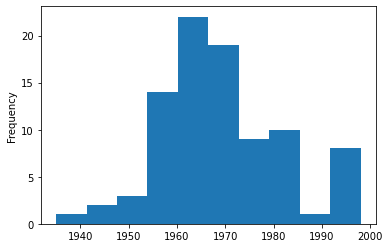

count      89.000000
mean     1969.359551
std        12.485671
min      1935.000000
25%      1961.000000
50%      1968.000000
75%      1977.000000
max      1998.000000
Name: repair_year_birth, dtype: float64
*************************************************************************
repair_country


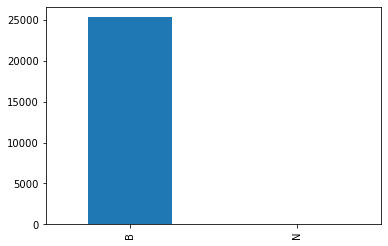

count     25345
unique        2
top           B
freq      25323
Name: repair_country, dtype: object
*************************************************************************
repair_sla


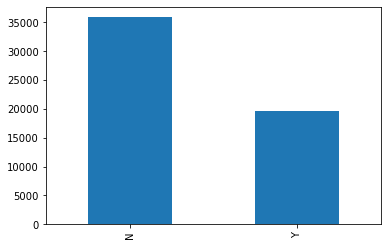

count     55463
unique        2
top           N
freq      35894
Name: repair_sla, dtype: object
*************************************************************************
policy_date_start


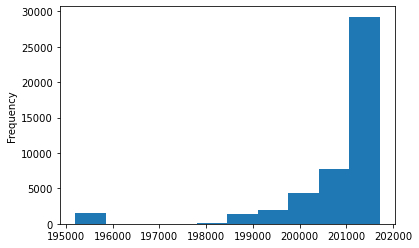

count     46312.000000
mean     200838.003865
std        1250.346279
min      195201.000000
25%      200707.000000
50%      201212.000000
75%      201508.000000
max      201712.000000
Name: policy_date_start, dtype: float64
*************************************************************************
policy_date_next_expiry


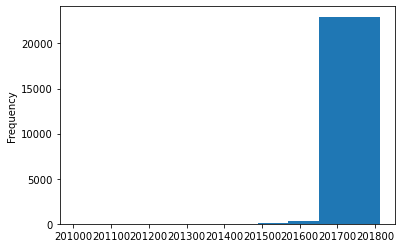

count     46312.000000
mean     201754.342913
std          52.988219
min      201005.000000
25%      201709.000000
50%      201712.000000
75%      201804.000000
max      201812.000000
Name: policy_date_next_expiry, dtype: float64
*************************************************************************
policy_date_last_renewed


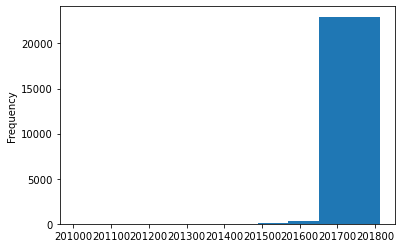

count     46312.000000
mean     201754.342913
std          52.988219
min      201005.000000
25%      201709.000000
50%      201712.000000
75%      201804.000000
max      201812.000000
Name: policy_date_last_renewed, dtype: float64
*************************************************************************
policy_num_changes


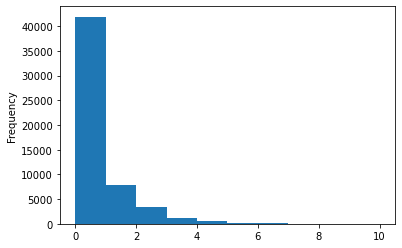

count    55463.000000
mean         0.425076
std          0.947263
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: policy_num_changes, dtype: float64
*************************************************************************
policy_num_claims


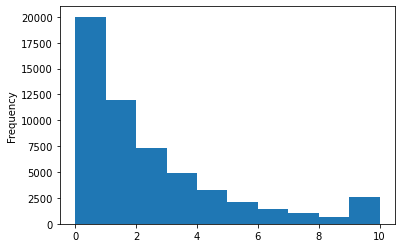

count    55463.000000
mean         2.034491
std          2.570084
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: policy_num_claims, dtype: float64
*************************************************************************
policy_premium_100


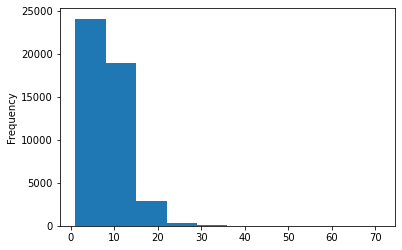

count    46301.000000
mean         7.947625
std          4.236660
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         71.000000
Name: policy_premium_100, dtype: float64
*************************************************************************
policy_coverage_1000


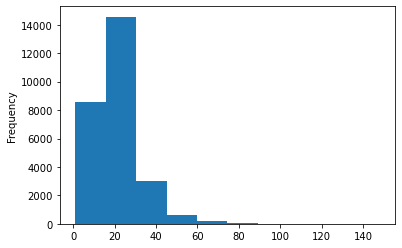

count    27043.000000
mean        21.537255
std         10.824431
min          1.000000
25%         14.000000
50%         19.000000
75%         26.000000
max        148.000000
Name: policy_coverage_1000, dtype: float64
*************************************************************************
policy_coverage_type
*******too many values to plot*******************
count          55463
unique            73
top       #000110000
freq           11705
Name: policy_coverage_type, dtype: object
*************************************************************************


In [13]:
for i in df.columns:
    print(i)
    try:
        df[i].plot(kind="hist")
        plt.show()
        print(df[i].describe())
    except TypeError:
        values = df[i].value_counts()
        if len(values) < 10:
            values.plot(kind="bar")
            plt.show()
            print(df[i].describe())
        else:
            print('*******too many values to plot*******************')
            print(df[i].describe())
    print('*************************************************************************')

In [121]:
corr[['fraud']][:int(np.round(len(corr)/2))]

,fraud
fraud,1.000000
claim_amount,0.170206
claim_liable,-0.026001
claim_num_injured,-0.007083
claim_num_third_parties,-0.046453
claim_num_vehicles,0.040726
claim_police,0.050361
claim_language,-0.042761
claim_vehicle_type,-0.009006
policy_holder_form,0.008863


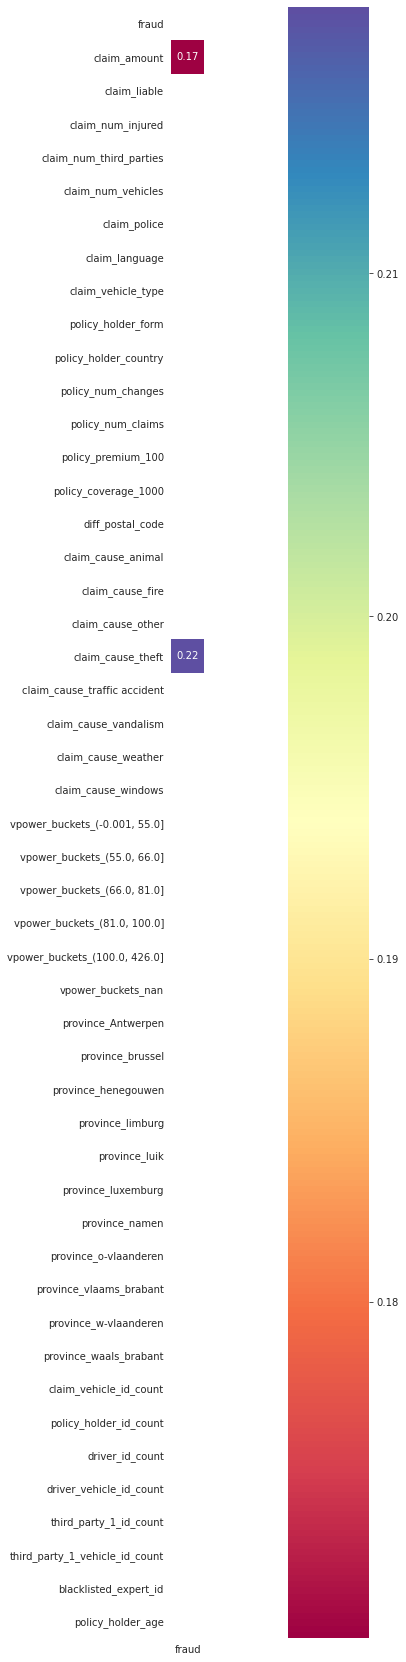

In [122]:
corr = df.corr()
corr=corr[['fraud']]
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask = ((mask + np.array(np.abs(corr) < 0.1)) > 0).astype(int)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(30, 30))
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
    ax = sns.heatmap(corr[["fraud"]], mask=mask, square=True, 
                     cmap="Spectral", annot=True)

# Data cleaning

In [4]:
df, ohe = update_dataset_features(df)

In [5]:
df.isna().sum()

fraud                                 0
claim_amount                          0
claim_liable                          0
claim_num_injured                     0
claim_num_third_parties               0
claim_num_vehicles                    0
claim_police                          0
claim_language                       43
claim_vehicle_type                  154
policy_holder_form                    0
policy_holder_country                 0
policy_num_changes                    0
policy_num_claims                     0
policy_premium_100                 9162
policy_coverage_1000              28420
diff_postal_code                      0
claim_cause_animal                    0
claim_cause_fire                      0
claim_cause_other                     0
claim_cause_theft                     0
claim_cause_traffic accident          0
claim_cause_vandalism                 0
claim_cause_weather                   0
claim_cause_windows                   0
vpower_buckets_(-0.001, 55.0]         0


# Train test split + prep

In [6]:
# claim_amount is currently dropped since poor performance
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:].drop(columns=["claim_amount"]), df["fraud"], test_size=.2, random_state=96)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df.drop(columns=["fraud", "claim_amount"]),
                                                                    df["claim_amount"], test_size=.2, random_state=96)

In [7]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
train_lang_mode = X_train["claim_language"].mode()[0]
train_vtype_mode = X_train["claim_vehicle_type"].mode()[0]

# mean
train_premium_mean = X_train["policy_premium_100"].mean()
train_coverage_mean = X_train["policy_coverage_1000"].mean()
train_policy_holder_mean_age = X_train["policy_holder_age"].mean()

for train_set in [X_train, X_train_reg]:
    train_set["claim_language"].fillna(train_lang_mode, inplace=True)
    train_set["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)
    train_set["policy_premium_100"].fillna(train_premium_mean, inplace=True)
    train_set["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
    train_set["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [8]:
# impute remaining missing values with mode or mean from train set on test set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

for test_set in [X_test, X_test_reg]:
    # mode
    test_set["claim_language"].fillna(train_lang_mode, inplace=True)
    test_set["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

    # mean
    test_set["policy_premium_100"].fillna(train_premium_mean, inplace=True)
    test_set["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
    X_test["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

# Defining eval metrics

In [9]:
def lift_score(y, y_prob):
    top_100_ranked_TP = pd.DataFrame(y_prob, y).reset_index().sort_values(by=0, ascending=False).iloc[:100]["fraud"].sum()
    avg_fraud_rate = y_train.sample(n=100, random_state=96).sum()
    lift = top_100_ranked_TP/avg_fraud_rate
    return lift

In [ ]:
def rr_at_100(y, y_prob):
    top_100_ranked_TP = pd.DataFrame(y_prob, y).reset_index().sort_values(by=0, ascending=False).iloc[:100]["fraud"].sum()
    avg_fraud_rate = y_train.sample(n=100, random_state=96).sum()
    lift = top_100_ranked_TP/avg_fraud_rate
    return lift

In [128]:
cost_mat_train[:,1]

array([2309.96,  706.18, 2452.76, ...,  935.  , 2437.89, 3200.6 ])

In [10]:
# set costs
cost_FN_train = df.iloc[X_train.index]["claim_amount"]
cost_FN_test = df.iloc[X_test.index]["claim_amount"]
c_FP = 5
c_TP = 5
c_TN = 0
cost_mat_train = np.array([c_FP * np.ones(X_train.shape[0]), cost_FN_train, 
                         c_TP * np.ones(X_train.shape[0]), 
                         c_TN * np.ones(X_train.shape[0])]).T

cost_mat_test = np.array([c_FP * np.ones(X_test.shape[0]), cost_FN_test, 
                         c_TP * np.ones(X_test.shape[0]), 
                         c_TN * np.ones(X_test.shape[0])]).T

In [11]:
# make different custom scorers
pr_score = make_scorer(average_precision_score, greater_is_better=True, 
                       needs_proba=True, average='weighted')
lift_scorer = make_scorer(lift_score, greater_is_better=True, needs_proba=True)

In [12]:
def model_evaluation(label, model, save_path=image_dir,
                     X_train=X_train, X_test=X_test, 
                     y_train=y_train, y_test=y_test, 
                     cost_mat_train=cost_mat_train, 
                     cost_mat_test=cost_mat_test):
    out = {}
    # auc
    yproba_train = model.predict_proba(X_train)[:,1]
    out["fpr_train"], out["tpr_train"], _ = roc_curve(y_train,  yproba_train)
    out["auc_train"] = roc_auc_score(y_train, yproba_train)
    yproba_test = model.predict_proba(X_test)[:,1]
    out["fpr_test"], out["tpr_test"], _ = roc_curve(y_test,  yproba_test)
    out["auc_test"] = roc_auc_score(y_test, yproba_test)
 
    # model savings
    try:
        out["savings_train"], out["savings_test"] = savings(X_train, y_train, 
                                                        X_test, y_test,
                                                        cost_mat_train, cost_mat_test,
                                                        model)
    except:
        out["savings_train"] = np.nan
        _, out["savings_test"] = savings(X_train, y_train, 
                                         X_test, y_test,
                                         np.zeros_like(X_train), cost_mat_test,
                                         model)
    # average_precision
    out["pr_train"] = pr_score(model, X_train, y_train)
    out["pr_test"] = pr_score(model, X_test, y_test)
    
    # lift
    out["lift_train"] = lift_scorer(model, X_train, y_train)
    out["lift_test"] = lift_scorer(model, X_test, y_test)
    
    # plot auc and save
    fig = plt.figure(figsize=(8,6))
    auc = np.round(out["auc_train"],2)
    plt.plot(out["fpr_train"], out['tpr_train'],
            label=f"{label} - train, AUC={auc}")
    auc = np.round(out["auc_test"],2)
    plt.plot(out["fpr_test"], out['tpr_test'],
            label=f"{label} - test, AUC={auc}")
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')
    fig.savefig(image_dir + label + '_roc.png')
    plt.show()
    return out

In [139]:
xgb_df = {'subsample': 0.8,
 'scale_pos_weight': 43.767857142857146,
 'reg_lambda': 3,
 'reg_alpha': 0.1,
 'n_estimators': 200,
 'min_child_weight': 20,
 'max_depth': 6,
 'learning_rate': 0.05,
 'gamma': 18,
 'colsample_bytree': 1.0,
 'base_score': 0.45999999999999996}

In [140]:
xgb_df = pd.DataFrame(xgb_df, index=[0])
print(xgb_df.to_latex(index=False))


\begin{tabular}{rrrrrrrrrrr}
\toprule
 subsample &  scale\_pos\_weight &  reg\_lambda &  reg\_alpha &  n\_estimators &  min\_child\_weight &  max\_depth &  learning\_rate &  gamma &  colsample\_bytree &  base\_score \\
\midrule
       0.8 &         43.767857 &           3 &        0.1 &           200 &                20 &          6 &           0.05 &     18 &               1.0 &        0.46 \\
\bottomrule
\end{tabular}



In [123]:
def create_latex_overview(final_out):
    df = pd.DataFrame()
    for model in final_out.keys():
        final_out[model]['model'] = model
        var_eval = ['model', 'savings_train', 'savings_test', 'pr_train', 'pr_test', 'lift_train', 'lift_test']
        df = df.append(pd.DataFrame({key: final_out[model][key] for key in final_out[model].keys() if key in var_eval}, index=[0]))
    print(df.to_latex(index=False))

In [14]:
final_out = {}

# Predicting claim amount - DO NOT USE

## Linear regression model

In [ ]:
lm = LinearRegression().fit(X_train_reg, y_train_reg)

In [ ]:
print("Training set R squared: {}".format(lm.score(X_train_reg, y_train_reg)))
print("Testing set R squared: {}".format(lm.score(X_test_reg, y_test_reg)))

In [ ]:
print('intercept:', lm.intercept_)
print('coef:', lm.coef_)

## Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=2, max_features="sqrt", 
                           random_state=96, warm_start=True, bootstrap=True)
model2 = rf.fit(X_train_reg, y_train_reg)

In [ ]:
print("Training set R squared: {}".format(model2.score(X_train_reg, y_train_reg)))
print("Testing set R squared: {}".format(model2.score(X_test_reg, y_test_reg)))

# Base Logistic Regression model - off the shelf

In [15]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [16]:
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

In [17]:
# we need to predict claim_amount on the testset to evaluate true performance
#X_test.drop(columns=["claim_amount"], inplace=True)
#X_test["claim_amount"] = model2.predict(X_test)

In [18]:
X_test_scaled = scaler.transform(X_test)

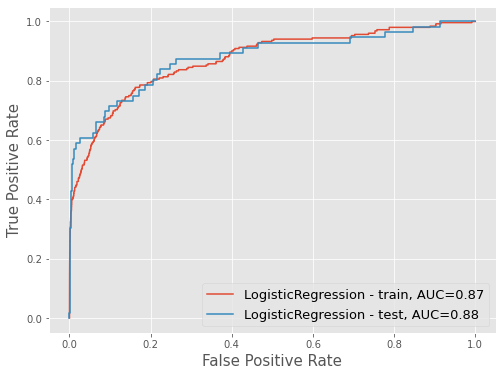

In [19]:
model_name = 'LogisticRegression'
final_out[model_name] = model_evaluation(model_name, clf, 
                        X_train=X_train_scaled, X_test=X_test_scaled)

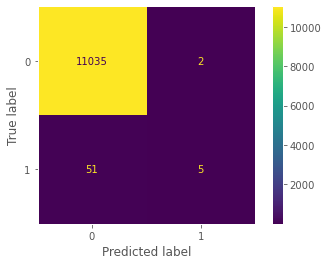

In [20]:
plot_confusion_matrix(clf, X_test_scaled, y_test)
plt.grid(False)
plt.show()

# Logistic Regression model - SMOTE

In [21]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [23]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [24]:
# transform the dataset
X_train_scaled_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)

In [25]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 44118
Minority class (1): 252
ratio: 0.571%
*********************************************************
Majority class (0): 17646
Minority class (1): 8823
ratio: 50.0%


In [26]:
clf_resampled = LogisticRegression(max_iter=500)
clf_resampled.fit(X_train_scaled_resampled, y_train_resampled)

LogisticRegression(max_iter=500)

C:\Users\u0143591\Documents\Code\kul_advanalytics\assignment1\eval_metrics.py:33: RuntimeWarning: invalid value encountered in double_scalars
  train_savings = np.round((max_cost_train - cost_train) / max_cost_train, 3)


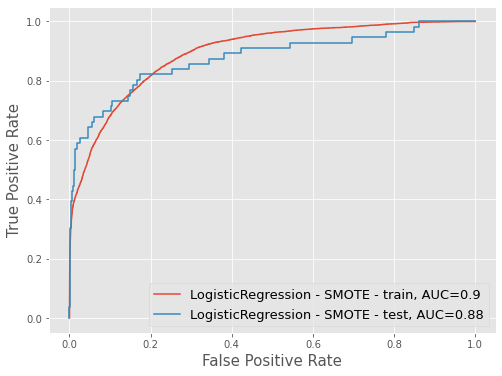

In [27]:
X_test_scaled = scaler.transform(X_test)
model_name = 'LogisticRegression - SMOTE'
# this will throw an error due to the fact that the cost matrix for train is 0
# and we divide by 0
final_out[model_name] = model_evaluation(model_name, clf_resampled, 
                                         X_train=X_train_scaled_resampled,
                                         y_train=y_train_resampled,
                                         X_test=X_test_scaled)

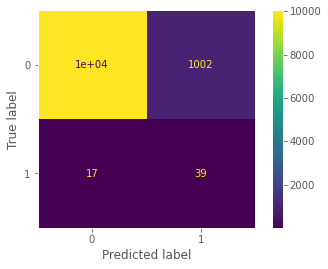

In [28]:
plot_confusion_matrix(clf_resampled, X_test_scaled, y_test)
plt.grid(False)
plt.show()

# Random Forest - SMOTE (not in report)

In [101]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [102]:
# transform the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [ ]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=20, class_weight='balanced_subsample', random_state=9, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

In [ ]:
plot_roc_curve(rf, X_test, y_test)

In [ ]:
plot_confusion_matrix(rf, X_test, y_test)
plt.grid(False)
plt.show()

# Balanced random forest

See [here](https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier)

In [129]:
over = SMOTE(sampling_strategy=0.4)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

In [130]:
# transform the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [31]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 44118
Minority class (1): 252
ratio: 0.571%
*********************************************************
Majority class (0): 44118
Minority class (1): 17647
ratio: 40.0%


In [32]:
# 0.60 savings
bclf = BalancedRandomForestClassifier(n_estimators=10000, max_depth=5, random_state=9, 
                                      n_jobs=-1, class_weight="balanced_subsample")

In [33]:
bclf.fit(X_train_resampled, y_train_resampled)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                               n_estimators=10000, n_jobs=-1, random_state=9)

C:\Users\u0143591\Documents\Code\kul_advanalytics\assignment1\eval_metrics.py:33: RuntimeWarning: invalid value encountered in long_scalars
  train_savings = np.round((max_cost_train - cost_train) / max_cost_train, 3)


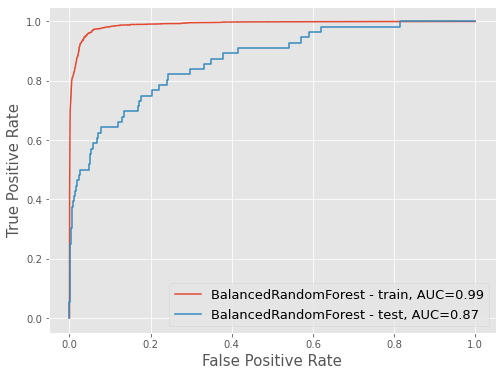

In [131]:
model_name = 'BalancedRandomForest'
# this will throw an error due to the fact that the cost matrix for train is 0
# and we divide by 0
final_out[model_name] = model_evaluation(model_name, bclf,
                                         X_train=X_train_resampled,
                                         X_test=X_test,
                                         y_train=y_train_resampled)

In [ ]:
plot_confusion_matrix(bclf, X_test, y_test)
plt.grid(False)
plt.show()

# XGB

see [here](https://xgboost.readthedocs.io/en/latest/parameter.html) for information on all parameters <br />
see [here](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py) and [here](https://github.com/tqchen/xgboost/tree/master/demo) for example of custom obj. function

In [141]:
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
ratio = neg_length/pos_length

In [ ]:
# See https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
# If you care only about the overall performance metric (AUC) of your prediction:
xgb_clf = xgb.XGBClassifier(n_estimators = 500, objective="binary:logistic", base_score=.99, eval_metric="logloss", seed=9, 
                            scale_pos_weight=1)

In [ ]:
# If you care about predicting the right probability:
# ^---- this is what we should do (IMO) --> 0.69 savings
xgb_clf = xgb.XGBClassifier(n_estimators = 100, objective="binary:logistic", eval_metric="auc", seed=9,
                            scale_pos_weight=ratio/5, reg_alpha=0.1, reg_lambda=3)

In [36]:
X_train.iloc[:,-9:] = X_train.iloc[:,-9:].astype(float)

In [ ]:
# create a weighted claim_amount
df["claim_amount_weighted"] = [df.loc[i, "claim_amount"] * 1.3  if df.loc[i, 'fraud'] == 1 else df.loc[i, "claim_amount"] * 1 for i in df.index]

In [ ]:
# calculate cost based on weighted claim amount or unweighted
cost = df.iloc[X_train.index]["claim_amount"]

In [ ]:
# sample-weighted XGB
xgb_clf = xgb.XGBClassifier(n_estimators = 100, objective="binary:logistic", eval_metric='auc', min_child_weight=1, seed=9,
                            sample_weight=cost)

In [ ]:
xgb_clf.fit(np.asarray(X_train), y_train)

In [37]:
# set grid params
params = {
        'n_estimators': [100, 150, 200, 250, 300, 400, 500, 600],
        'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5, 7, 10, 20, 30],
        'reg_lambda': [0.5, 1, 1.5, 2, 3, 4, 5],
        'subsample': [0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'scale_pos_weight': [ratio/i for i in np.arange(1,11)] + [1],
        'reg_alpha': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
        'base_score': list(np.arange(0.1,1,0.09)),
        'gamma': list(np.arange(0,22,3))
        }

In [38]:
xgb_clf2 = xgb.XGBClassifier(objective="binary:logistic", seed=9)

In [39]:
# make grid search pipeline
over = SMOTE(sampling_strategy=0.4, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
pipeline = make_pipeline(over, under, xgb_clf2)

In [40]:
# rename params
new_params = {'xgbclassifier__' + key: params[key] for key in params}

In [72]:
# apply randomized grid search CV
cv = StratifiedKFold(n_splits=5, shuffle=True)
random_search = RandomizedSearchCV(pipeline, param_distributions=new_params, n_iter=600, 
                                   scoring={'lift':lift_scorer, 'auc':'roc_auc', 'pr':pr_score, 'savings':savings}, n_jobs=-1, cv=cv, 
                                   verbose=3, random_state=49, refit="lift")

In [73]:
# fit random search cv
xgb_search = random_search.fit(np.asarray(X_train), y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\Users\u0143591\Anaconda3\envs\sust_iot\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\u0143591\Anaconda3\envs\sust_iot\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [74]:
# print best params
xgb_search.best_params_

{'xgbclassifier__subsample': 0.7,
 'xgbclassifier__scale_pos_weight': 19.452380952380953,
 'xgbclassifier__reg_lambda': 4,
 'xgbclassifier__reg_alpha': 0.2,
 'xgbclassifier__n_estimators': 300,
 'xgbclassifier__min_child_weight': 7,
 'xgbclassifier__max_depth': 4,
 'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__gamma': 12,
 'xgbclassifier__colsample_bytree': 0.6,
 'xgbclassifier__base_score': 0.64}

In [ ]:
# print results of cv
pd.DataFrame(xgb_search.cv_results_)

In [ ]:
# save restuls in json
import json
with open('output_pr.json', 'w+') as f:
    json.dump(xgb_search.best_params_, f)

In [93]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", subsample= 0.8,
                            scale_pos_weight=43.767857142857146,
                            reg_lambda=3,
                            reg_alpha=0.1,
                            n_estimators=200,
                            min_child_weight=20,
                            max_depth=6,
                            learning_rate=0.05,
                            gamma=18,
                            colsample_bytree=1.0,
                            base_score=0.45999999999999996)

In [105]:
xgb_clf.fit(np.asarray(X_train_resampled), y_train_resampled)

C:\Users\u0143591\Anaconda3\envs\sust_iot\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:15:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.45999999999999996, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=18, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=20, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0.1, reg_lambda=3,
              scale_pos_weight=43.767857142857146, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

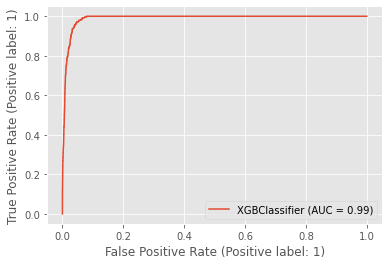

In [106]:
plot_roc_curve(xgb_clf, np.asarray(X_train), y_train)
plt.show()

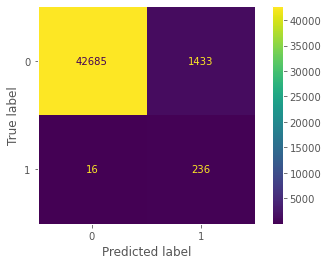

In [107]:
plot_confusion_matrix(xgb_clf, np.asarray(X_train), y_train)
plt.grid(False)
plt.show()

In [108]:
X_test.iloc[:,-9:] = X_test.iloc[:,-9:].astype(float)

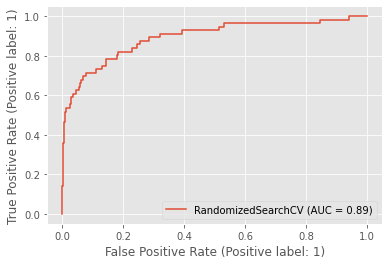

In [109]:
plot_roc_curve(xgb_search, np.asarray(X_test), y_test)

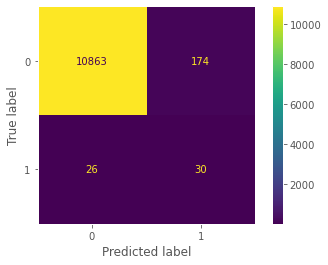

In [110]:
plot_confusion_matrix(xgb_search, np.asarray(X_test), y_test)
plt.grid(False)
plt.show()

C:\Users\u0143591\Documents\Code\kul_advanalytics\assignment1\eval_metrics.py:33: RuntimeWarning: invalid value encountered in long_scalars
  train_savings = np.round((max_cost_train - cost_train) / max_cost_train, 3)


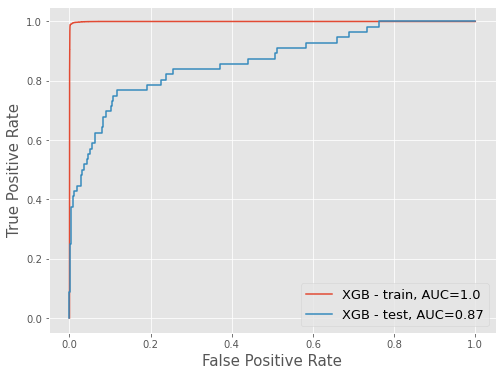

In [111]:
model_name = 'XGB'
# this will throw an error due to the fact that the cost matrix for train is 0
# and we divide by 0
final_out[model_name] = model_evaluation(model_name, xgb_clf,
                                         X_train=np.asarray(X_train_resampled),
                                         X_test=np.asarray(X_test),
                                         y_train=y_train_resampled)

# Overview


In [125]:
create_latex_overview(final_out)

\begin{tabular}{rrrrrrl}
\toprule
 savings\_train &  savings\_test &  pr\_train &  pr\_test &  lift\_train &  lift\_test &                      model \\
\midrule
         0.218 &         0.170 &  0.293161 & 0.306482 &   19.666667 &   9.333333 &         LogisticRegression \\
           NaN &         0.799 &  0.834662 & 0.262283 &   33.000000 &   7.666667 & LogisticRegression - SMOTE \\
           NaN &         0.656 &  0.979964 & 0.213043 &   33.333333 &   7.000000 &       BalancedRandomForest \\
           NaN &         0.654 &  0.999548 & 0.239646 &   33.333333 &   7.000000 &                        XGB \\
\bottomrule
\end{tabular}



# Submission

In [125]:
submit_path = r"./test.csv"

In [126]:
submit_set = pd.read_csv(submit_path, sep=";", encoding="utf-8-sig")

In [131]:
sorted(submit_set["claim_date_registered"])

[20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180101,
 20180102,
 20180102,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,
 20180104,

In [ ]:
# convert binary text variables into binary: {"Y":1, "N":0}
for i in ["claim_liable", "claim_police", "driver_injured"]:
    text_to_binary(i, "Y", "N", submit_set)
# {"P":1, "N":0}
text_to_binary("claim_alcohol", "P", "N", submit_set)
# {"car":1, "van":0}
text_to_binary("claim_vehicle_type", "car", "van", submit_set)
# {"M":1, "F":0}
text_to_binary("policy_holder_form", "M", "F", submit_set)
# {"B":1, "N":0}
text_to_binary("policy_holder_country", "B", "N", submit_set)
# make claim_lang binary (currently 1:Dutch, 2:Fr) -> 0: Dutch and 1: French
submit_set["claim_language"] = submit_set["claim_language"] - 1 

# add buckets for vehicle power
submit_set["vpower_buckets"] = pd.qcut(submit_set["claim_vehicle_power"], 5)

# add provinces based on postal code
postal_bins = [999, 1299, 1499, 1999, 2999, 3499, 3999, 4999, 5999, 6599, 6999, 7999, 8999, 9999]
postal_label = ["brussel", "waals_brabant", "vlaams_brabant", 'Antwerpen', 'vlaams_brabant', 'limburg', 
                'luik', 'namen', 'henegouwen', 'luxemburg', 'henegouwen', 'w-vlaanderen', 'o-vlaanderen']
submit_set["province"] = pd.cut(submit_set["claim_postal_code"], postal_bins, labels=postal_label, ordered=False)

# add feature that describes if policy holders postal code is same as claim postal code
submit_set["diff_postal_code"] = (submit_set["policy_holder_postal_code"] == submit_set["claim_postal_code"]).astype(float)

# get dummies for cat vars
submit_set = encode(ohe, submit_set, ['claim_cause', 'vpower_buckets', 'province'])
#df = encode_ph_postal_code(phpc_ohe, df)

# format date
YYYYMMDD_date_columns = ["claim_date_registered",
                         "claim_date_occured"]
for i in YYYYMMDD_date_columns:
    submit_set[i] = pd.to_datetime(submit_set[i], format="%Y%m%d")

# remove extreme value
submit_set["claim_vehicle_date_inuse"].replace(to_replace=270505.0, value= np.nan, inplace=True)

YYYYMM_columns = ["claim_vehicle_date_inuse", 
                  "policy_date_start",
                  "policy_date_next_expiry",
                  "policy_date_last_renewed"]
for i in YYYYMM_columns:
    submit_set[i] = pd.to_datetime(submit_set[i], format="%Y%m")

In [ ]:
# Add the extra features just like we did for the training set
submit_set = add_extra_features(submit_set)

In [ ]:
# Hide the claim_id column as index so that it's not used as covariate for the prediction, but we can recover
# it later as we need claim_id in the output .csv file
submit_set = submit_set.set_index('claim_id')
#df = df[X_train.drop(columns=["claim_amount"]).columns]
submit_set = submit_set[X_train.columns]


In [ ]:
submit_set.isna().sum()

In [ ]:
submit_set.to_csv('submit.csv')

In [ ]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

data = {
    "data":
    [
        {
            'Column2': "example_value",
            'claim_liable': "0",
            'claim_num_injured': "0",
            'claim_num_third_parties': "0",
            'claim_num_vehicles': "0",
            'claim_police': "0",
            'claim_language': "0",
            'claim_vehicle_type': "0",
            'policy_holder_form': "0",
            'policy_holder_country': "0",
            'policy_num_changes': "0",
            'policy_num_claims': "0",
            'policy_premium_100': "0",
            'policy_coverage_1000': "0",
            'diff_postal_code': "0",
            'claim_cause_animal': "0",
            'claim_cause_fire': "0",
            'claim_cause_other': "0",
            'claim_cause_theft': "0",
            'claim_cause_traffic accident': "0",
            'claim_cause_vandalism': "0",
            'claim_cause_weather': "0",
            'claim_cause_windows': "0",
            'vpower_buckets_(-0.001, 55.0]': "0",
            'vpower_buckets_(55.0, 66.0]': "0",
            'vpower_buckets_(66.0, 81.0]': "0",
            'vpower_buckets_(81.0, 100.0]': "0",
            'vpower_buckets_(100.0, 426.0]': "0",
            'vpower_buckets_nan': "0",
            'province_Antwerpen': "0",
            'province_brussel': "0",
            'province_henegouwen': "0",
            'province_limburg': "0",
            'province_luik': "0",
            'province_luxemburg': "0",
            'province_namen': "0",
            'province_o-vlaanderen': "0",
            'province_vlaams_brabant': "0",
            'province_w-vlaanderen': "0",
            'province_waals_brabant': "1",
            'claim_vehicle_id_count': "0",
            'policy_holder_id_count': "0",
            'driver_id_count': "0",
            'driver_vehicle_id_count': "0",
            'third_party_1_id_count': "0",
            'third_party_1_vehicle_id_count': "0",
            'blacklisted_expert_id': "false",
            'policy_holder_age': "0",
            'pct1': "0",
            'pct2': "0",
            'pct3': "0",
            'pct4': "0",
            'pct5': "0",
            'pct6': "0",
            'pct7': "0",
            'pct8': "0",
            'pct9': "0",
        },
    ],
}

body = str.encode(json.dumps(data))

url = 'http://be62a776-8b23-41b0-a6d2-0f61a6e64323.francecentral.azurecontainer.io/score'
api_key = '' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

In [ ]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
submit_set["claim_language"].fillna(train_lang_mode, inplace=True)
submit_set["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

# mean
submit_set["policy_premium_100"].fillna(train_premium_mean, inplace=True)
submit_set["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
submit_set["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [ ]:
assert submit_set.isna().sum().sum() == 0

In [ ]:
# While we don't have a model yet to predict claim_amount, set it to 0.0
# TODO: Replace this with the predicted response variable of the regression model on the submission set.
#df['claim_amount'] = model2.predict(df)

In [ ]:
submit_scaled = scaler.transform(submit_set)

In [ ]:
submit_not_scaled = submit_set.copy()

In [ ]:
# final submission set initialization
submission = submit_set.reset_index()[['claim_id']]

In [ ]:
# for logistic regression
submission["prediction"] = clf.predict_proba(submit_scaled)[:,1]

In [ ]:
# for logistic regression with SMOTE
submission["prediction"] = clf_resampled.predict_proba(submit_scaled)[:,1]

In [ ]:
# for rf with SMOTE
submission["prediction"] = rf.predict_proba(submit_not_scaled)[:,1]

In [ ]:
# for balanced random forest
submission["prediction"] = bclf.predict_proba(submit_not_scaled)[:,1]

In [ ]:
# for xgb
submit_not_scaled.iloc[:,-9:] = submit_not_scaled.iloc[:,-9:].astype(float)
submission["prediction"] = xgb_clf.predict_proba(submit_not_scaled)[:,1]

In [ ]:
# for cost-sensitive xgb
submit_not_scaled.iloc[:,-9:] = submit_not_scaled.iloc[:,-9:].astype(float)
submission["prediction"] = xgb_clf.predict_proba(np.asarray(submit_not_scaled))[:,1]

In [ ]:
# for cost-sensitive ann
submission["prediction"] = clf.predict(np.asarray(submit_not_scaled).astype(np.float32), verbose=1)

In [ ]:
# for randomsearch xgb
submit_not_scaled.iloc[:,-9:] = submit_not_scaled.iloc[:,-9:].astype(float)
submission["PROB"] = xgb_search.predict_proba(np.asarray(submit_not_scaled))[:,1]

In [ ]:
submission.columns = ["ID", "PROB"]

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission_V0.53.csv", sep=',', index=False)